불확실성 고려 

- 오차 행렬과, 분류 리포트가 예측결과를 분석 할 수 있도록 도와주지만 예측값은 모델에 담긴 많은 정보가 이미 손실된 상태이다. 
- 분류기의 예측 확신을 가늠하기 위한 decision_function, predict_proba 메서드를 제공하낟. 
- 예측을 만드는 것은 decision_function, predict_proba출력의 임계값을 검증하는 것.
- 이진 탐색에서는 0.5를 각 임계값으로 사용한다. 


In [3]:
#SVM학습시킨 모델을 decision_function 0일 떄의 임계점확인
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(n_samples = (400, 50), cluster_std = [7.0, 2], random_state = 22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
svc = SVC(gamma = .05).fit(X_train, y_train)

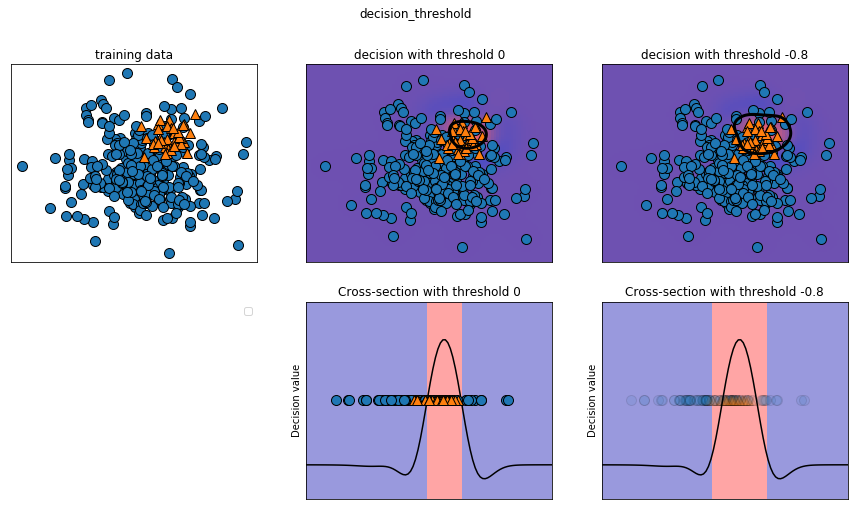

In [5]:
import mglearn
mglearn.plots.plot_decision_threshold()

In [6]:
#classification_report를 통한 두 클래스의 정밀도와 재현율 평가 
from sklearn.metrics import classification_report

print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



클래스 0의 샘플이 매우 많으므로 분류기는 소수인 클래스 1보다 0에 초점을 맞추고 있다. 

이 모델이 암진단 예와 같이 클래스 1의 재현율을 높이는 것이 중요하다고 가정해 본다. 

In [7]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [8]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



- 클래스 1의 재현율(recall)이 높아지고 정밀도(precision)은 낮아졌다. 

- 데이터가 심하게 불균형일 경우 결정 함수의 임계값을 바꾸면 더 나은 결과를 얻을 수 있다. 

- decision_function은 임의의 범위를 가지고 있으므로 임계점을 고르는 일반적인 방법을 제시하기는 어렵다. 

- 임계값을 선택할 때, 테스트 셋을 사용하지 않도록 주의해야한다. 

- (과도하게 낙관적인 결과를 만들어, 테스트셋 대신 검증 세트 혹은 교차검증 이용이 효과적이다. )

- predict_proba를 제공하는 메서드는 출력이 0~1 사이 고정이므로 이를 제공하는 모델은 임계깞 선택이 더 쉽다. 

- 임계값이 0.5인 모델은 양성 클래스라는 확신이 50%이상일 때 양성으로 분류한다. 

- 임의의 임계값보다는 확률을 사용하는 쪽이 더 직관적이지만, 모든 모델이 쓸모 있는 불확실성을 제공하는 것은 아니다.

- 이는 보정과 연관되어 있어, 보정된 모델은 불확실성을 정확하게 측정하는 모델이다. 
  (보정에 대한 자세한 개념은 https://bit/ly/2LfMILV 참고 )

정밀도 - 재현율 곡선과 ROC곡선

- 모델의 분류작업을 결정하는 임계값을 바꾸는 것은 해당 분류기의 정밀도와 재현율의 상충관계를 조정하는 일이다. 
- FN를 10%보다 작게하여 90%이상의 재현율을 원할 수도 있는데 이는 모델의 비즈니스 목표에 따라 결정된다. 
- 이때 어려운 부분은 임계깞을 유지하며 적절항 정밀도를 만들어 내는 모델을 만드는 일이다. 
- 분류기의 필요조건을 지정하는 것을 운영포인트를 지정한다고 말한다. (비즈니스 목표설정, 성능 보장시 도움)
- 새로운 모델 개발시 운영포인트가 명확하지 않은 경우가 많아, 문제를 더 잘 이해하기 위해 모든 임계값을 조사하거나,

  정밀도나 재현율의 모든 장단점을 살펴보는 것이 좋다. (정밀도 - 재현율 곡선 이용)
- 정밀도-재현율 곡선은 타겟 레이블과 decision_function, predict_proba메서드로 계산한 예측 불확실성을 이용한다. 

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve( y_test, svc.decision_function(X_test))

precision_recall_curve 함수는 가능한 모든 임계값에 대해 정밀도와 재현율의 값을 정렬된 리스트로 반환하여 곡선 그래프를 그릴 수 있다. 

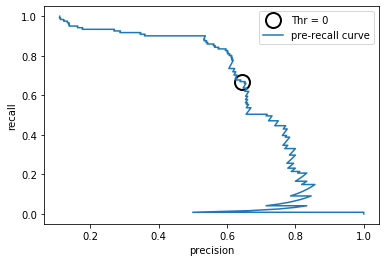

In [13]:
#부드러운 곡선위한 데이터 포인트 수 늘림
import numpy as np
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples = (4000, 500), cluster_std=[7.0,2], random_state = 22)
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 0)

svc = SVC(gamma = .05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

#0에 가까운 임계값 탐색
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=15, label = 'Thr = 0', fillstyle='none',c='k',mew =2)

plt.plot(precision, recall, label = 'pre-recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')

곡선의 각 포인트는 decision_function의 가능한 모든 임계값에 대응한다. 

임계값이 0인 지점은 predict 메서드를 호출할 때 사용되는 임계값이다. 

곡선이 오른쪽 위로 갈수록 더 좋은 분류기 이다. 

이 분류기는 임계값이 매우 낮아 전부 양성 클래스가 되는 왼쪽에서 시작한다. 

재현율과 정밀도를 둘다 높게 가져갈 수는 없는 모델이다.

분류기가 다르면 곡선의 다른 부분에서 장점이 생긴다. (운영포인트가 달라진다. )

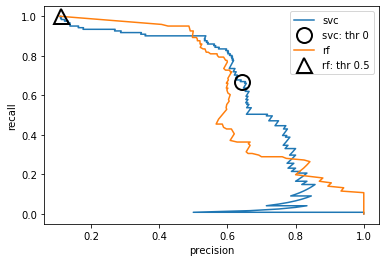

In [17]:
#랜덤포레스트와의 비교 

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 2)
rf.fit(X_train, y_train)

#rf는 predict_proba 제공
precision_rf, recall_rf, thresholds_rf = precision_recall_curve( y_test, rf.predict_proba(X_test)[:,1])

plt.plot(precision, recall, label='svc')

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize = 15, 
        label='svc: thr 0', fillstyle = 'none', c='k', mew = 2)

plt.plot(precision_rf, recall_rf, label='rf')

#predict_proba의 기본 임계값은 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf))

plt.plot(precision[close_default_rf], recall[close_default_rf], '^', c='k', markersize= 15, 
        label = 'rf: thr 0.5', fillstyle = 'none', mew =2)

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')